In [1]:
# Import all the libraries we need
import os

import parsl
from parsl import python_app
from parsl.config import Config
from parsl.executors import HighThroughputExecutor
from parsl.providers import LocalProvider

# Helper functions
from grouputils import initialize_stager
from grouputils import plot_tiles
from grouputils import initialize_rasterizer

## Background - Step 1

The first step in our workflow is to "stage" our data. Staging the data encompasses the following pre-processing tasks:

- simplify the polygons 
- set an input CRS if one is missing
- reproject the data when required
- add additional properties to each polygon, including:
  - the centroid x and y coordinates
  - area
  - a unique ID
  - name of the file that the
  polygon originated from
- break each input file into [standardized tiles](https://docs.opengeospatial.org/is/17-083r2/17-083r2.html)
- identify duplicate polygons (those that occur in two staged tiles)
- save them to disk, following a file hierarchy and naming format for x, y, and z coordinates of the tiles

Here is a diagram showing what the most important step, the last one, looks like.

![](https://raw.githubusercontent.com/PermafrostDiscoveryGateway/viz-staging/develop/docs/images/staging_tldr.png)

We will use some methods from the `pdgstaging` library to stage our tiles. The first step, is to initalize the `TileStager`. The `TileStager` is a class with a method `stage`, which works on a single vector file.

### Initalize the stager

Fist we need to use the `initialize_stager` function to instantiate the `TileStager` object. The only argument to this function is `dir_input`, the directory of input data.

Input vector files are located **in `/home/shares/example-pdg-data/SCC-2023`**

In [2]:
# Execute the initialize_stager function with the path for the input data
# Save the result to a variable called iwp_stager
iwp_stager = initialize_stager("/home/shares/example-pdg-data/SCC-2023")

The `iwp_stager` object works as a tool that communicates the configuration settings to the staging function. The stager tells the staging function:
- where to pull the input files from
- where to write the staged tiles
- the coordinate reference system to use, by passing the TileMatrixSet
- whether the input data should be deduplicated, etc.

Next let's use it to get a list of files to stage.

In [3]:
files_to_stage = iwp_stager.tiles.get_filenames_from_dir('input')

In [4]:
files_to_stage

['/home/shares/example-pdg-data/SCC-2023/GE01_20180907225323_1050010012146100_18SEP07225323-M1BS-502583898040_01_P003_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20090828220948_101001000A2D0F00_09AUG28220948-M1BS-052802016020_01_P003_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20060817224711_101001000525AC00_06AUG17224711-M1BS-052220659010_01_P001_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20090828220951_101001000A2D0F00_09AUG28220951-M1BS-052802016020_01_P004_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20090828220955_101001000A2D0F00_09AUG28220955-M1BS-052802016020_01_P005_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/QB02_20110722215239_101001000DD28400_11JUL22215239-M1BS-052802088070_01_P001_u16rf3413_pansh.gpkg',
 '/home/shares/example-pdg-data/SCC-2023/WV02_20130820230329_1030010025318400_13AUG20230329-M1BS-500124702020_01_P003_u16rf3413_pansh.gpkg',
 '/home/share

## Stage one file

Here is an example of how to run the stager on one file. We use the `stage` method on the `iwp_stager` object, with a path to a file as the argument to the method.

In [5]:
example_file = files_to_stage[1] # file = 88.3 MB

iwp_stager.stage(example_file)

DriverError: NULL pointer error

Check out your driectory `scalable-computing-course/group-project` - you'll see that a subdirectory called `staged` has been created. This directory contains the `.gpkg` files output. To check how many staged files were created, you can run the command: `find group-project/staged -type f | wc -l`

### Estimating total computation time

Based on how long staging one file took, estimate how long that would take to stage all 11 input files, serially.

In [ ]:
# Estimate computation time for 11 files
1.25 * 11

13.75

Due to the different sizes of each input file, it can be difficult to predict how long it will actually take. All the files that make up this small data sample are very small relative to other files in the compelete dataset, so our calculation results in an underestimate when we scale up the workflow. The largest file in this dataset sample is 88.2 MB, and an average ice wedge polygon file is around 400 MB, resulting in a processing time of many minutes.

Additionally, a computer's resources are limited by the amount of people concurrently processing files and writing them (I/0 wait). When a machine is writing a file, it is not "working", it's waiting for the file to be written. When many users are writing files, a queue builds up.

### Scaling up the workflow

Computation time also depends on the machine you're working on. With more input GeoPackages from this dataset, it is common to run into an "out of memory" error that cancels the entire process when run serially. Tools such as `htop` and `glances` help with monitorting memory, CPU usage, and which accounts are runnning each process on a server. If a process is running slower than you would expect, you can check these dashboards to diagnose the problem. If your dashbord shows your memory is steadily increasing and reaches >90%, that's a sign your process will crash! When doing test runs with your data, it is important to monitor your memory to determine how the usage will increase in addition to the number of output files. 

The complete ice wedge polygon dataset contains **26,530** GeoPackages. How long would it take to process all of them serially, assuming they all took the same amount of time as our example file? Recall this your answer will be an underestimate!

In [ ]:
# Estimate computation time for all 26,530 files
1.25 * 26530 / 60 / 24

23.02951388888889

### Visualizing staged tiles

As the number of files gets bigger, things get out of hand quickly. Luckily for us, this problem is pleasingly parallel. The staging of each file is completely independent of the others. So, let's set this up as a `parsl` workflow using the skills we learned in Section 4: Pleasingly Parallel Programming.

Just to get a sense of what happened, let's plot the result of our test staging effort using a `plot_tiles` helper function we wrote for this activity.

DriverError: Failed to open dataset (flags=68): staged/WGS1984Quad/13/897/1060.gpkg

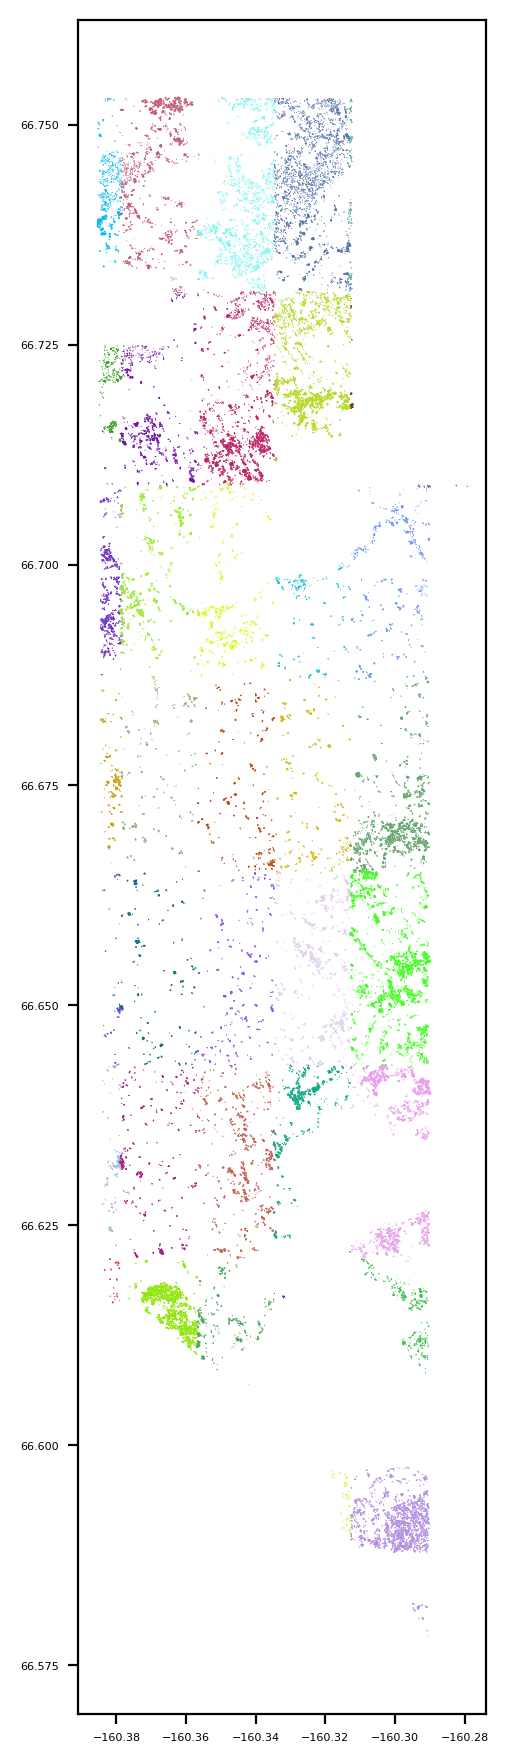

In [6]:
plot_tiles(iwp_stager) 

Finally, let's remove the files we just created (including the staging summary csv file that's generated with the staged files) to prepare to run this over all of the files. If we don't do this, polygons will get appended to the staged files which will result in duplication.

We also need to refresh the stager to its original state for a new staging instance.

In [7]:
# Remove files and staged directory
os.system(f'rm -rf {iwp_stager.config.get("dir_staged")}')
os.system(f'rm {iwp_stager.config.get("filename_staging_summary")}')

# Refresh the stager
iwp_stager = initialize_stager("/home/shares/example-pdg-data/SSC-2023")

## Staging in parallel

#### Which exector should we use?

First set up the configuration for `parsl` using `config`, and a `HighThroughputExecutor` (`parsl` has many executor options). We are working on a single node with 88 cores, so we have the choice between `HighThroughputExecutor` or `ThreadPoolExecutor`. We chose to use `HighThroughputExecutor` because it avoids long job scheduler queue delays by acquiring a set of resources initially, allowing it to schedule _multiple tasks_ on a single node! 

Using the other exector actually makes our execution time longer. With this set of input data and imported libraries, achieveing parallelization with the `ThreadPoolExecutor` is largely limited by python's "global interpreter lock". This is a lock that allows only 1 thread to hold control of the python interpreter. One way to avoid the global interpreter lock is to use multi-processing approach, rather than a multi-threaded approach. This works because each python process gets its own interpreter and memory space. This is exactly what we are doing with the `HighThroughputExecutor`! This executor coordinates tasks over several cores in a node.

#### Configuration

For the executor, set the `max_workers_per_node` to 11, and set the `max_blocks` to 1. This will spread our work over 11 processes on the server.

A "block" is the most basic unit of resources to be aquired from a provider. A block has a different definition depending on the kind of server you're working on (whether you have been allocated multiple nodes, or do work on _one node_ that has multiple _cores_). We are working on a multi-core node, we wouldn't want to set our blocks to be higher than 1, because a block _at minimum_ is 1 node.

There are plenty of `parsl` configuration options out there, but many are not relevant for our server and do not speed up the process. 

Make sure you pass the bash command you use to invoke your virtual environment to the `worker_init` argument as a string.

In [8]:
# TEMPLATE FOR PARSL CONFIG:

activate_env = 'workon scomp'
htex_config = Config(
  executors=[
      HighThroughputExecutor(
          max_workers_per_node=11, 
          provider = LocalProvider(
            worker_init = activate_env,
            max_blocks = 1
          )
      )
  ]
)

parsl.clear()
parsl.load(htex_config)

Next, set up your Parsl app to run the `stage` method in parallel. You'll need to pass 2 arguments to the app function:
1. The path to the input file.
2. The `TileStager` instance we created earlier.

Note how the function returns the input path. This will give us something to interate over, since the `stage` method returns `None` (and writes files!)

In [9]:
# Make a Parsl app that uses the stage method
# Function arguments: path, stager

@python_app
def stage_file(path, stager):
    """Stage a file using the stager"""
    # Run the stage method on the stager
    stager.stage(path)
    # Return the staged path
    return path

Now, execute the app in parallel over all of the `files_to_stage`. In this solution, we use a simple loop to run our `parsl` app, and then list comprehension to retrieve the result from our futures.

In [10]:
# Execute the app using app.futures

futures = []
for file in files_to_stage:
    # Call the stage_file app
    future = stage_file(file, iwp_stager)
    # Append the future to the list
    futures.append(future)
    print(f"Staging file: {file}")

# Wait for the app to finish
for future in futures:
    # Get the result
    staged_path = future.result()
    # Print the staged path
    print(f"Staged path: {staged_path}")




Staging file: /home/shares/example-pdg-data/SCC-2023/GE01_20180907225323_1050010012146100_18SEP07225323-M1BS-502583898040_01_P003_u16rf3413_pansh.gpkg
Staging file: /home/shares/example-pdg-data/SCC-2023/QB02_20090828220948_101001000A2D0F00_09AUG28220948-M1BS-052802016020_01_P003_u16rf3413_pansh.gpkg
Staging file: /home/shares/example-pdg-data/SCC-2023/QB02_20060817224711_101001000525AC00_06AUG17224711-M1BS-052220659010_01_P001_u16rf3413_pansh.gpkg
Staging file: /home/shares/example-pdg-data/SCC-2023/QB02_20090828220951_101001000A2D0F00_09AUG28220951-M1BS-052802016020_01_P004_u16rf3413_pansh.gpkg
Staging file: /home/shares/example-pdg-data/SCC-2023/QB02_20090828220955_101001000A2D0F00_09AUG28220955-M1BS-052802016020_01_P005_u16rf3413_pansh.gpkg
Staging file: /home/shares/example-pdg-data/SCC-2023/QB02_20110722215239_101001000DD28400_11JUL22215239-M1BS-052802088070_01_P001_u16rf3413_pansh.gpkg
Staging file: /home/shares/example-pdg-data/SCC-2023/WV02_20130820230329_1030010025318400_13AU

Don't forget to shutdown your executor and clear `parsl`.

In [12]:
# Shutdown and clear the parsl executor
htex_config.executors[0].shutdown()
parsl.clear()

Now we can check out the `plot_tiles` result again (which will only plot the first 45 of our tiled files)

454 are present.             Only plotting the first 45 files.


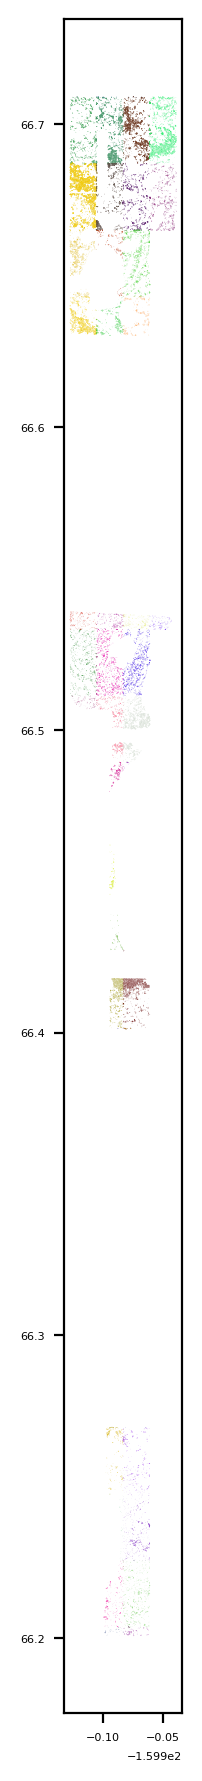

In [13]:
plot_tiles(iwp_stager) 

## Background: Step 2

![](https://raw.githubusercontent.com/PermafrostDiscoveryGateway/viz-raster/develop/docs/images/raster_tldr.png)

Today, we will create rasters from the regularly gridded staged data from yesterday (vector data, left side of diagram above). Each pixel of the raster will contain a stasticic calculated based on the underlying vector data for that pixel.

The two statistics we calculate are:

- number of IWP per pixel
- proportion of pixel covered by IWP

The vector data on the left are geopackages, which can be read in as simple geodataframes. The rasters take the geometry columns of all the geodataframes, which are all simple polygons, and represent them as pixels. 

Similar to the `TileStager` from the first step of the group project, in this step we will use a `RasterTiler` class, which we initialize using `initialize_rasterizer`.

In [14]:
# Execute the initialize_rasterizer function with the filepath for the input data
# Save the result to a variable called iwp_rasterizer
iwp_rasterizer = initialize_rasterizer("/home/shares/example-pdg-data/SCC-2023")

Similarly to how the `iwp_stager` communicated configuration information to the stager, the `iwp_rasterizer` communicates  information to the rasterizer. This includes:

- where the staged files are located
- where to write the raster files
- size of the rasters (in pixels)
- what statistics to calculate (each becomes a band)

In [15]:
staged_paths = iwp_rasterizer.tiles.get_filenames_from_dir('staged')
print(len(staged_paths), "files to rasterize.")

454 files to rasterize.


We can use the `rasterize_vector` method on our `RasterTiler` class object, and pass it the first file in our list of staged files to rasterize just one file.

In [16]:
iwp_rasterizer.rasterize_vector(staged_paths[0])

Tile(x=909, y=1059, z=13)

This went pretty quickly, but with hundreds of files, it would still be beneficial to parallelize. Estimate the length of time it would take to process the files in series below:

In [17]:
# estimate duration of rasterization process
0.9 * 454

408.6

## Rasterize in Parallel

Given what you know about the limits of parallelization, discuss in your group whether you think this problem is:

- cpu-bound
- memory-bound
- I/O-bound
- network-bound

How does it compare to the parallelization task from step 1?

Instead of parallelizing this step over all 454 files, we will instead process the data in batches of files. Below is a function we can use to make batches of files.

In [18]:
# Because rasterization is relatively quick, we want each parsl "task" to process a batch of tiles.
def make_batch(items, batch_size):
    # Create batches of a given size from a list of items.
    return [items[i:i + batch_size] for i in range(0, len(items), batch_size)]

Use the `make_batch` function to make batches of 10 items each of our staged data (`staged_paths`).

In [19]:
# make batches of 10 files
batches = make_batch(staged_paths, 10)
batches

[['staged/WGS1984Quad/13/909/1059.gpkg',
  'staged/WGS1984Quad/13/909/1060.gpkg',
  'staged/WGS1984Quad/13/909/1061.gpkg',
  'staged/WGS1984Quad/13/909/1068.gpkg',
  'staged/WGS1984Quad/13/909/1069.gpkg',
  'staged/WGS1984Quad/13/909/1067.gpkg',
  'staged/WGS1984Quad/13/909/1062.gpkg',
  'staged/WGS1984Quad/13/909/1063.gpkg',
  'staged/WGS1984Quad/13/910/1059.gpkg',
  'staged/WGS1984Quad/13/910/1060.gpkg'],
 ['staged/WGS1984Quad/13/910/1061.gpkg',
  'staged/WGS1984Quad/13/910/1062.gpkg',
  'staged/WGS1984Quad/13/910/1067.gpkg',
  'staged/WGS1984Quad/13/910/1068.gpkg',
  'staged/WGS1984Quad/13/910/1069.gpkg',
  'staged/WGS1984Quad/13/910/1070.gpkg',
  'staged/WGS1984Quad/13/910/1071.gpkg',
  'staged/WGS1984Quad/13/910/1072.gpkg',
  'staged/WGS1984Quad/13/910/1073.gpkg',
  'staged/WGS1984Quad/13/910/1074.gpkg'],
 ['staged/WGS1984Quad/13/910/1079.gpkg',
  'staged/WGS1984Quad/13/910/1080.gpkg',
  'staged/WGS1984Quad/13/910/1081.gpkg',
  'staged/WGS1984Quad/13/910/1082.gpkg',
  'staged/WGS1

Now, set up your Parsl executor again, with `max_workers_per_node` set at 11 and `max_blocks` set at 1.

In [20]:
# TEMPLATE FOR PARSL CONFIG:

activate_env = 'workon scomp'
htex_config = Config(
  executors=[
      HighThroughputExecutor(
          max_workers_per_node=11, 
          provider = LocalProvider(
            worker_init = activate_env,
            max_blocks = 1
          )
      )
  ]
)

parsl.clear()
parsl.load(htex_config)

Next, set up your Parsl app to run the `rasterize_vectors` method in parallel, including an argument for `make_parents=False`. Note that you'll be using `rasterize_vectors` (plural) rather than the singular `rasterize_vector` method we tried above. Remember that Parsl apps cannot rely on global variables or package imports, so you'll need to make sure to pass the app all of the variables it needs.

In [21]:
# Make a Parsl app that uses the rasterize_vectors method

@python_app
def rasterize_file(batch, rasterizer):
    """Rasterize a file"""
    # Run the rasterize_vectors method on the rasterizer
    rasterized = rasterizer.rasterize_vectors(batch, make_parents=False)
    # Return the staged path
    return rasterized

Now, execute the app in parallel over all of the batches of files you created previously.

While you wait for _all_ the geotiffs to be written, you can monitor the process with the command: `find group-project/geotiff -type f | wc -l` 

The total number of geotiffs for this step will be equivalent to the number of staged files.

In [22]:
# Rasterize the batches in parallel

futures = []
for batch in batches:
    # Call the stage_file app
    future = rasterize_file(batch, iwp_rasterizer)
    # Append the future to the list
    futures.append(future)
    print(f"Assembled futures for: {batch}")

# Wait for the app to finish
for future in futures:
    # Get the result
    rasterized_batch = future.result()
    # Print the staged path
    print(f"Rasterized file: {rasterized_batch}")

Assembled futures for: ['staged/WGS1984Quad/13/909/1059.gpkg', 'staged/WGS1984Quad/13/909/1060.gpkg', 'staged/WGS1984Quad/13/909/1061.gpkg', 'staged/WGS1984Quad/13/909/1068.gpkg', 'staged/WGS1984Quad/13/909/1069.gpkg', 'staged/WGS1984Quad/13/909/1067.gpkg', 'staged/WGS1984Quad/13/909/1062.gpkg', 'staged/WGS1984Quad/13/909/1063.gpkg', 'staged/WGS1984Quad/13/910/1059.gpkg', 'staged/WGS1984Quad/13/910/1060.gpkg']
Assembled futures for: ['staged/WGS1984Quad/13/910/1061.gpkg', 'staged/WGS1984Quad/13/910/1062.gpkg', 'staged/WGS1984Quad/13/910/1067.gpkg', 'staged/WGS1984Quad/13/910/1068.gpkg', 'staged/WGS1984Quad/13/910/1069.gpkg', 'staged/WGS1984Quad/13/910/1070.gpkg', 'staged/WGS1984Quad/13/910/1071.gpkg', 'staged/WGS1984Quad/13/910/1072.gpkg', 'staged/WGS1984Quad/13/910/1073.gpkg', 'staged/WGS1984Quad/13/910/1074.gpkg']
Assembled futures for: ['staged/WGS1984Quad/13/910/1079.gpkg', 'staged/WGS1984Quad/13/910/1080.gpkg', 'staged/WGS1984Quad/13/910/1081.gpkg', 'staged/WGS1984Quad/13/910/1082

Don't forget to add lines to shut down the executor and clear `parsl`.

In [23]:
htex_config.executors[0].shutdown()
parsl.clear()

Check to make sure that you have the same number of GeoTIFF files as we do staged vector tiles:

In [24]:
geotiff_paths = iwp_rasterizer.tiles.get_filenames_from_dir('geotiff')
len(geotiff_paths) == len(staged_paths)

True

In [25]:
import rasterio

with rasterio.open(geotiff_paths[3], "r") as src:
    data = scr.read(1)

import matplotlib.pyplot as plt
plt.imshow(data, cmap="gray")

NameError: name 'scr' is not defined

## Bonus Questions

Step 1 took the original 11 files, ranging in size from 6 MB to 88 MB (all files = about 0.5 GB), and tiled them into 454 geopackage files. 

Discuss in your groups whether you suspect this process is CPU bound, I/O bound, memory bound, or network bound. 

How would you figure it out for sure?

Why would you want to know?





How would you test whether this Step 2 is CPU or I/O bound? One option would be to test whether adding more CPU decreases your computation time. Set up a test on a subset of the staged files (the first 100 or so is fine) and time the process at different `max_workers_per_node`. To make sure you don't overload the server, do not exceed 15 workers in your tests.